### (1) import
- MNIST data : 우편번호 글씨 수집

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

### (2) Generator

In [ ]:
# def gen_block(self, in_channel, out_channel, kernel_size=4, stride=2, final_layer=False):
#   if not final_layer:
#     return nn.Sequential(
#         nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride),
#         nn.BatchNorm2d(out_channel),
#         nn.ReLU(inplace=True),
#     )
#   else:
#     return nn.Sequential(
#         nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
#         nn.Tanh(),
#     )

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_sim=10, in_chan=1, hidden_dim=64):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    # Build the neural network
    self.gen = nn.Sequential(
        self.gen_block(z_dim, hidden_dim * 4), # 첫 번째는 3, 2
        self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1), # 두 번째는 4, 1
        self.gen_block(hidden_dim * 2, hidden_dim), # 세 번째는 3, 2
        self.gen_block(hidden_dim, in_chan, kernel_size=4, final_layer=True), # 마지막에는 4, 2
    )

  # def gen_block
  def gen_block(self, in_channel, out_channel, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride),
          nn.BatchNorm2d(out_channel),
          nn.ReLU(inplace=True),
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
          nn.Tanh(), # tanh => -1 ~ 1까지 나오므로 값을 제한하기 위해 사용함
      )

  def unsqueeze_noise(self, noise):
    return noise.view(len(noise), self.z_dim, 1, 1)

  def forward(self, noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

### (3) Discriminator

In [ ]:
# def disc_block(self, in_channel, out_channel, kernel_size=4, stride=2, final_layer=False):
#   if not final_layer:
#     return nn.Sequential(
#         nn.Conv2d(in_channel, out_channel, kernel_size, stride),
#         nn.BatchNorm2d(out_channel),
#         nn.LeakyReLU(0.2, inplace=True)
#     )
#   else:  # Final layer
#     return nn.Sequential(
#         nn.Conv2d(in_channel, out_channel, kernel_size, stride)
#     )


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, im_chan=1, hidden_dim=16):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        self.disc_block(im_chan, hidden_dim),
        self.disc_block(hidden_dim, hidden_dim * 2),
        self.disc_block(hidden_dim * 2, 1, final_layer = True),
    )

  # def disc_block
  def disc_block(self, in_channel, out_channel, kernel_size=4, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size, stride),
          nn.BatchNorm2d(out_channel),
          nn.LeakyReLU(0.2, inplace=True)
      )
    else:  # Final layer
      return nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size, stride)
      )

  def forward(self, image):
    disc_pred = self.disc(image)
    return disc_pred.view(len(disc_pred), -1)


### (4) noise 생성

In [ ]:
def get_noise(n_samples, z_dim, device="cpu"):
  return torch.randn(n_samples, z_dim, device=device)

### (5) 기타

### (5-1) 파라미터 세팅

In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cpu'

### (5-2) 데이터 로드

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),                                  
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### (5-3) 초기화

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

### (6) image display

In [ ]:
# (6) image display
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
  image_unflat = image_tensor.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

### (7) training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 500, Generator loss : 1.8009093687534319, Discriminator loss : 0.2875454250425098


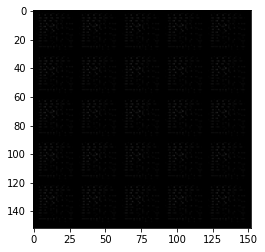

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


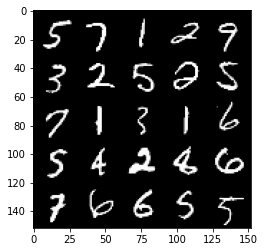

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1000, Generator loss : 2.6811791915595533, Discriminator loss : 0.16914956690371022


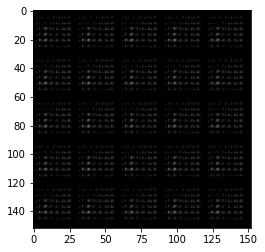

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


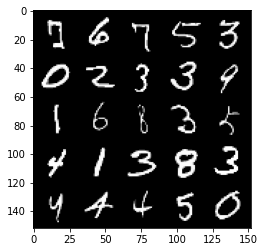

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1500, Generator loss : 3.190828564167024, Discriminator loss : 0.07229775758087642


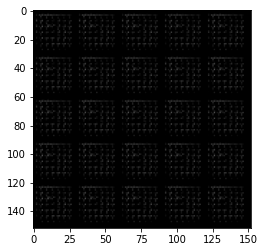

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


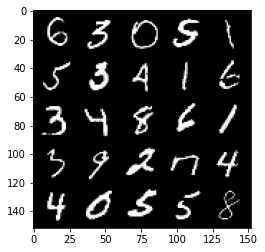

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 2000, Generator loss : 4.007808875083924, Discriminator loss : 0.035040305258706245


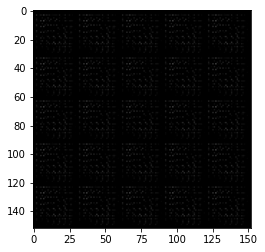

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


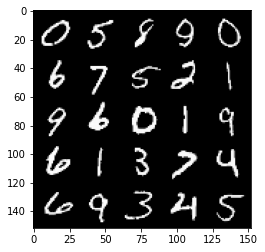

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 2500, Generator loss : 4.329582028388975, Discriminator loss : 0.021934907585382468


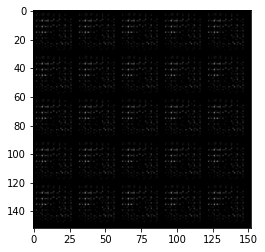

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


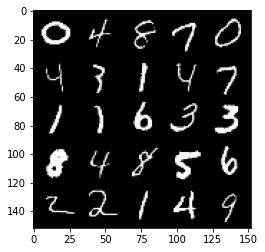

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 3000, Generator loss : 4.90075979423523, Discriminator loss : 0.012867002204060547


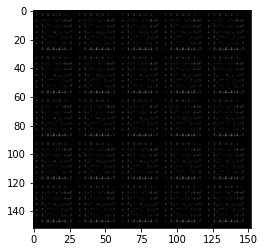

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


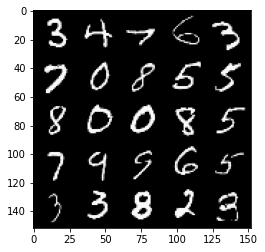

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 3500, Generator loss : 5.450087082862852, Discriminator loss : 0.007715779444668445


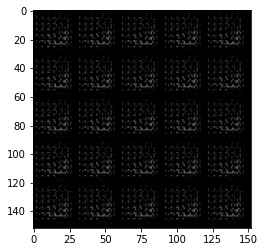

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


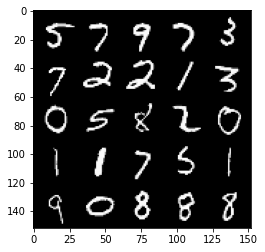

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 4000, Generator loss : 5.8832901372909605, Discriminator loss : 0.006043702661059799


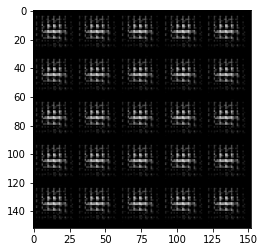

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


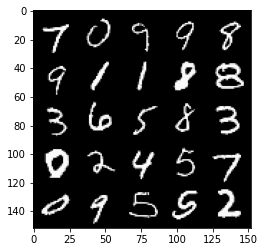

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 4500, Generator loss : 2.408321323446931, Discriminator loss : 0.41126049865270053


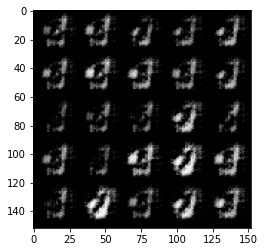

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


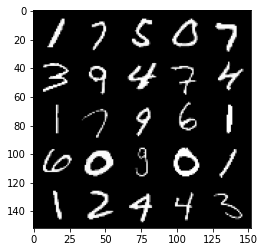

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 5000, Generator loss : 1.7888182838410147, Discriminator loss : 0.3846454867497089


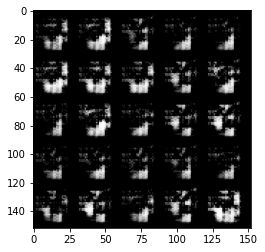

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


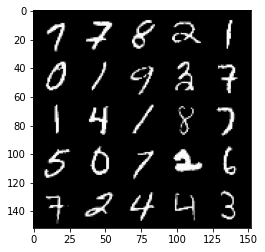

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 5500, Generator loss : 1.4354462374746797, Discriminator loss : 0.43001154497265826


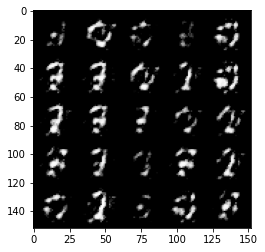

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


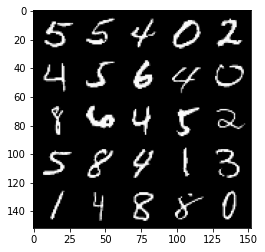

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 6000, Generator loss : 1.4676138479188086, Discriminator loss : 0.46530398957431285


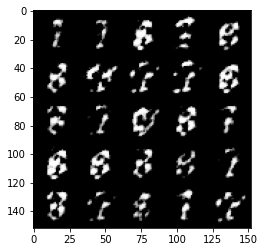

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


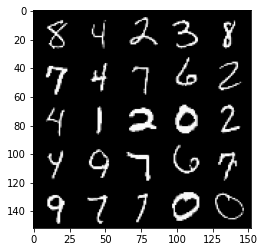

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 6500, Generator loss : 1.475389692842962, Discriminator loss : 0.46014120960235627


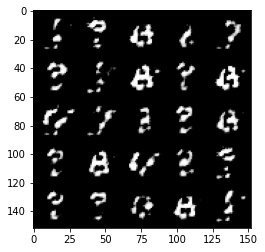

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


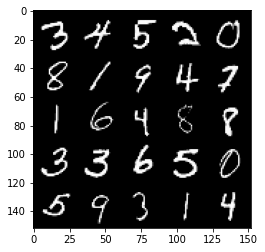

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 7000, Generator loss : 1.2201859356015934, Discriminator loss : 0.5198284148573873


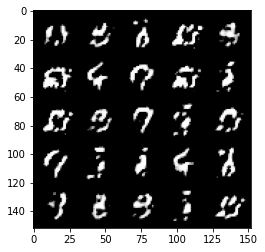

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


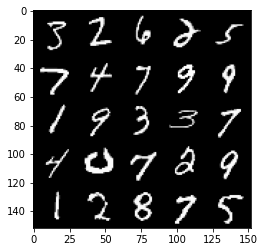

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 7500, Generator loss : 1.02111612740159, Discriminator loss : 0.575418129384518


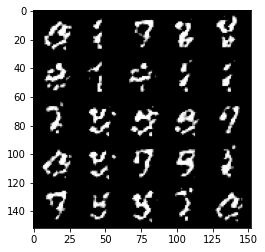

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


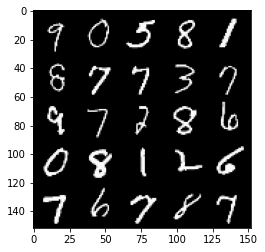

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 8000, Generator loss : 0.9193655889630323, Discriminator loss : 0.6108180100917815


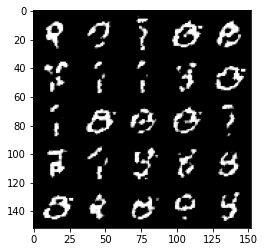

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


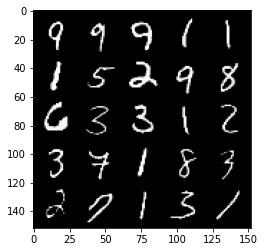

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 8500, Generator loss : 0.8336185782849787, Discriminator loss : 0.6483336439132692


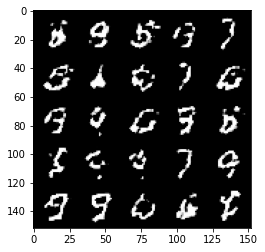

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


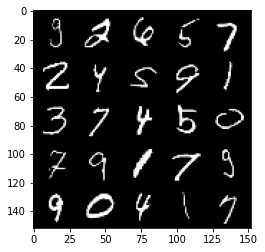

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 9000, Generator loss : 0.8054744672179224, Discriminator loss : 0.6649444311857224


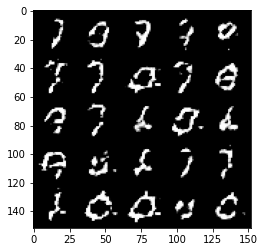

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


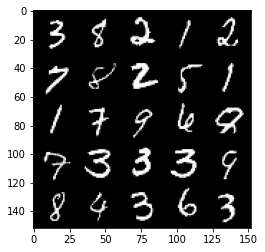

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 9500, Generator loss : 0.8116594183444978, Discriminator loss : 0.6662530963420858


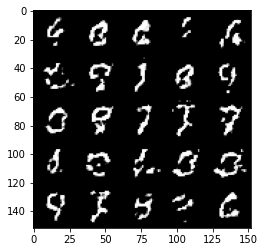

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


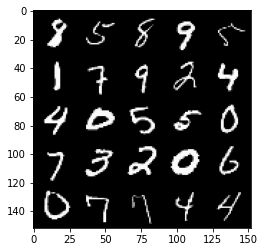

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 10000, Generator loss : 0.7853145219087593, Discriminator loss : 0.6686416631937022


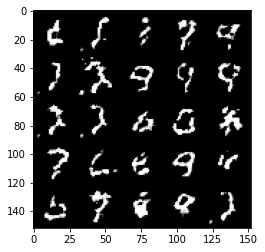

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


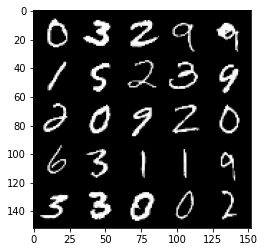

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 10500, Generator loss : 0.7727556109428413, Discriminator loss : 0.6762040632963179


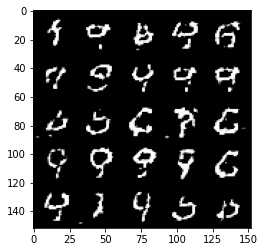

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


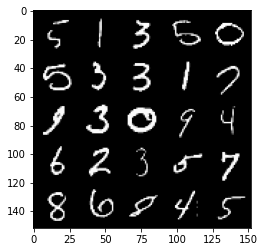

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 11000, Generator loss : 0.7567024893760672, Discriminator loss : 0.6835553200244899


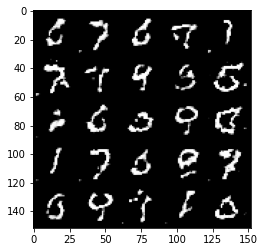

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


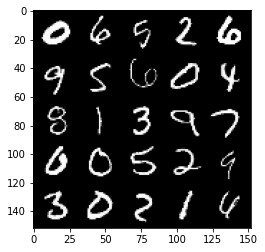

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 11500, Generator loss : 0.7479933691024777, Discriminator loss : 0.6871222068071362


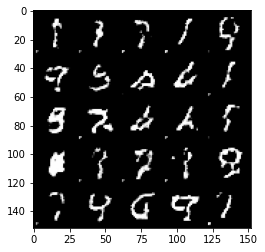

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


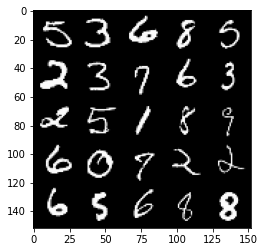

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 12000, Generator loss : 0.7349918493032461, Discriminator loss : 0.6957398759126657


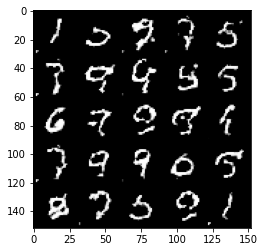

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


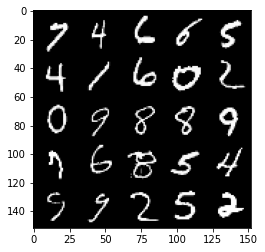

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 12500, Generator loss : 0.7293489964008333, Discriminator loss : 0.6966211271286015


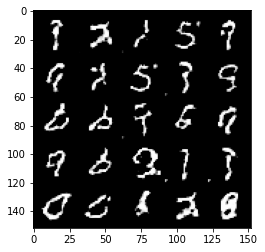

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


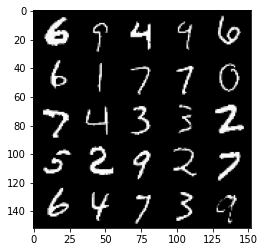

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 13000, Generator loss : 0.7224120705127716, Discriminator loss : 0.7006754119396216


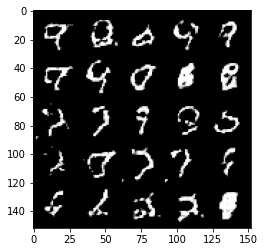

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


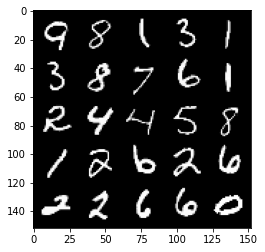

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 13500, Generator loss : 0.7168580775260924, Discriminator loss : 0.7033383102416987


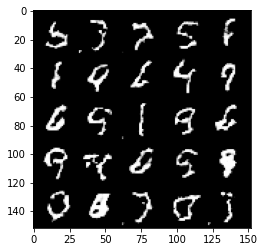

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


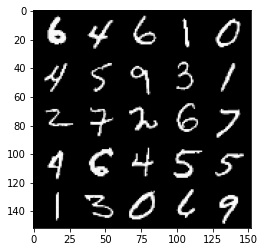

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 14000, Generator loss : 0.7093079453706742, Discriminator loss : 0.7041981660127644


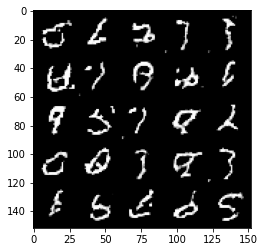

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


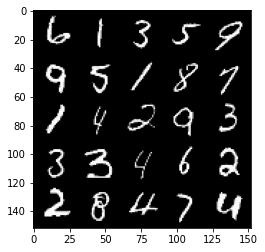

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 14500, Generator loss : 0.7077619016170502, Discriminator loss : 0.7051586863994598


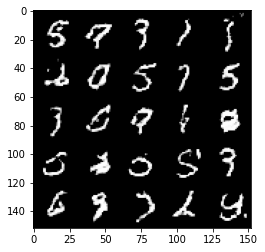

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


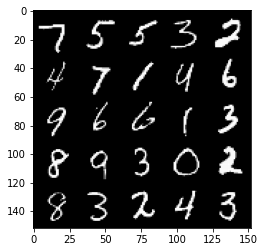

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 15000, Generator loss : 0.7075056838989252, Discriminator loss : 0.7043260958194733


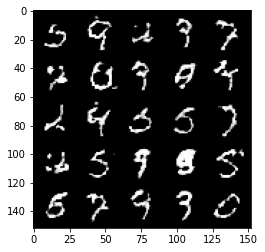

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


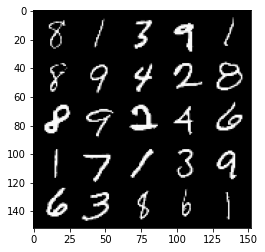

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 15500, Generator loss : 0.7063556518554693, Discriminator loss : 0.7046337780952455


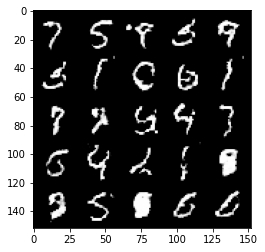

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


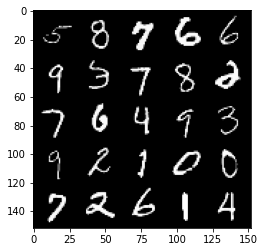

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 16000, Generator loss : 0.7010605001449585, Discriminator loss : 0.7023957791328426


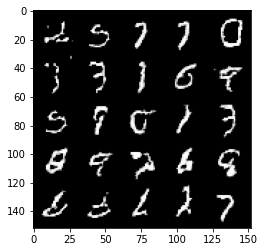

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


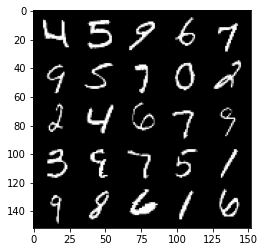

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 16500, Generator loss : 0.7014353406429295, Discriminator loss : 0.7020632053613651


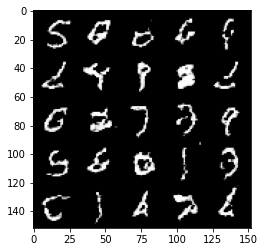

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


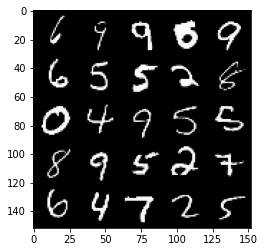

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 17000, Generator loss : 0.7016901358366001, Discriminator loss : 0.7020834528207776


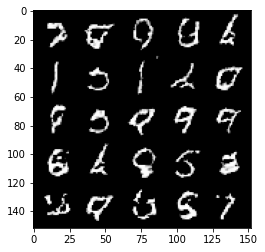

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


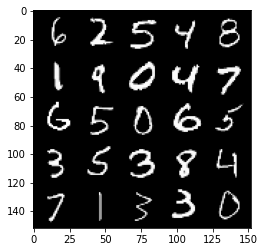

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 17500, Generator loss : 0.6981475845575343, Discriminator loss : 0.7020379784107209


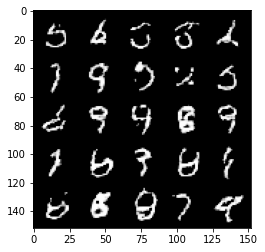

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


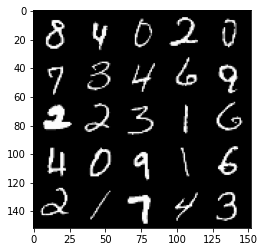

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 18000, Generator loss : 0.6983770194053645, Discriminator loss : 0.7027806183099746


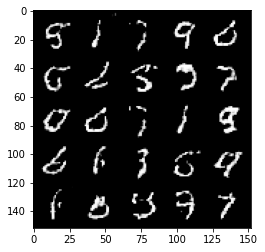

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


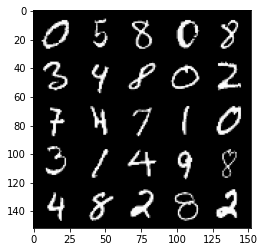

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 18500, Generator loss : 0.6963842701911921, Discriminator loss : 0.702417478919029


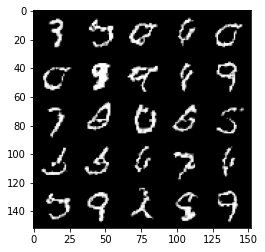

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


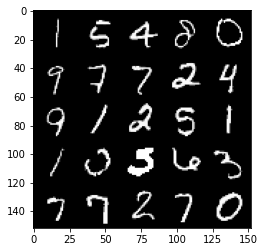

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 19000, Generator loss : 0.6941615749597554, Discriminator loss : 0.7018932585716239


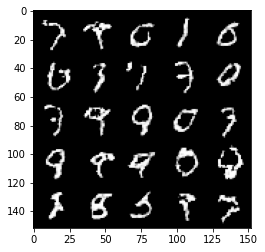

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


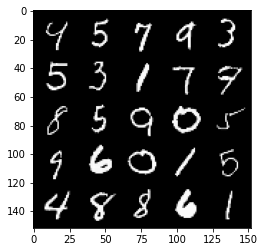

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 19500, Generator loss : 0.6955100600719446, Discriminator loss : 0.7025055989027016


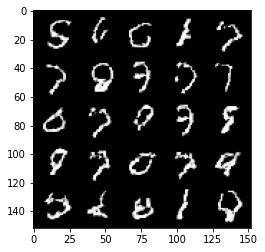

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


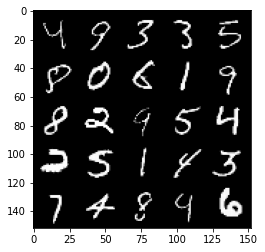

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 20000, Generator loss : 0.6939408302307132, Discriminator loss : 0.7011478064060218


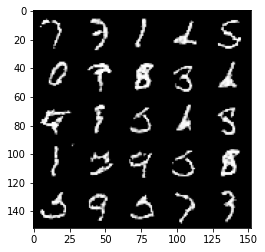

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


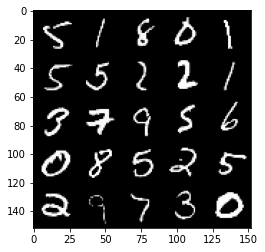

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 20500, Generator loss : 0.6943104250431059, Discriminator loss : 0.7014845626354216


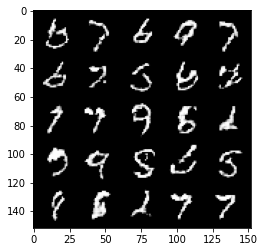

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


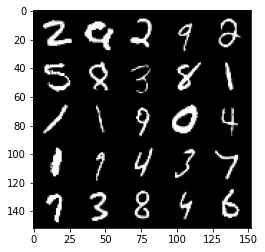

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 21000, Generator loss : 0.6935980943441388, Discriminator loss : 0.7009243314266203


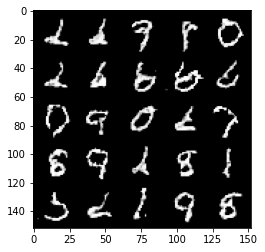

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


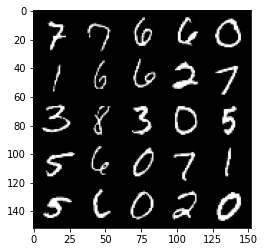

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 21500, Generator loss : 0.694109586238862, Discriminator loss : 0.7004126938581474


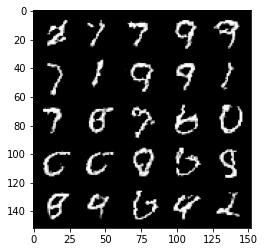

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


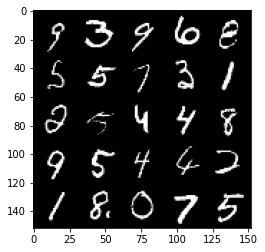

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 22000, Generator loss : 0.695165123939514, Discriminator loss : 0.6995729005336762


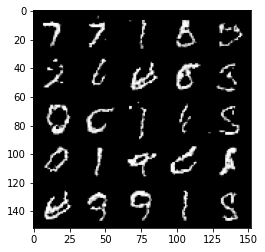

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


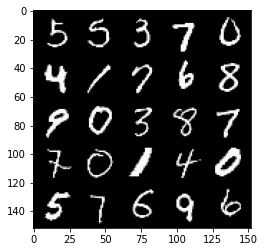

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 22500, Generator loss : 0.6936619180440898, Discriminator loss : 0.6986914809942254


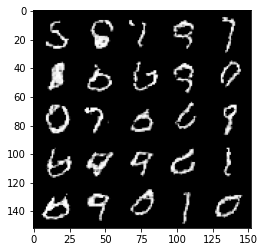

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


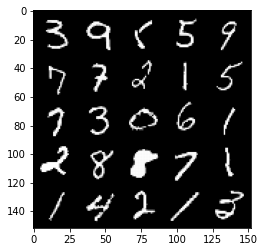

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 23000, Generator loss : 0.697394020557404, Discriminator loss : 0.6983521893024445


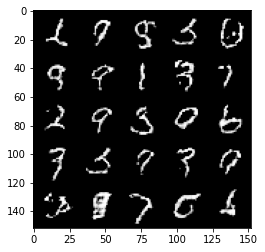

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


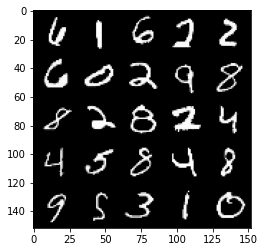

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.to(device)

    # update disc
    disc_opt.zero_grad()
    latent = get_noise(cur_batch_size, z_dim, device=device) # z
    fake = gen(latent) # G(z)
    disc_fake_pred = disc(fake.detach()) # D(G(z)) -> 미분을 사용하지 않겠다. grad 를 빼고 가져오는 것이다.
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) # log(1-D(G(z)))
    disc_real_pred = disc(real) # D(x)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred)) # log(D(x))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    # track the average disc loss
    mean_discriminator_loss += disc_loss.item() / display_step
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    # update gen
    gen_opt.zero_grad()
    latent_2 = get_noise(cur_batch_size, z_dim, device=device) # z
    fake_2 = gen(latent_2) # G(z)
    disc_fake_pred = disc(fake_2) # D(G(z)) -> 미분을 사용하겠다.
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    gen_loss.backward()
    gen_opt.step()

    # Track the average gen loss
    mean_generator_loss += gen_loss.item() / display_step

    # visualize the results
    if cur_step % display_step == 0 and cur_step > 0:
      print(f"step : {cur_step}, Generator loss : {mean_generator_loss}, Discriminator loss : {mean_discriminator_loss}")
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    cur_step += 1